In [3]:
"""
CS 677 Data Science with Python
#########################################
Project          - Interest Rate prediction
Creation Date    - 15/04/2019
Student Name     - Gautam Gowrishankar

Note: First few code blocks are the exact ones from Pre-Processing notebook.
      Random Forest implementation starts after ~8 blocks.
      Input file: Features_data_final.csv
"""


import pandas as pd
import numpy as np
import os

# Making a list of missing value types
missing_values = ["n/a", "na", "--", "??"]

#Read csv file into pandas dataframe
#df = pd.read_csv("loan.csv", na_values = missing_values, low_memory=False)
import io
df = pd.read_csv(io.BytesIO(uploaded['loan.csv']))

print("No.of columns -",len(df.columns))

df.head()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (19,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


No.of columns - 74


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,1077501,1296599,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,1314167,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1077175,1313524,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,C5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1076863,1277178,10000.0,10000.0,10000.0,36 months,13.49,339.31,C,C1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1075358,1311748,3000.0,3000.0,3000.0,60 months,12.69,67.79,B,B5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
#Let the cleansing commence

#Drop unused Columns
df.drop(['funded_amnt_inv','installment','emp_title','pymnt_plan','url','desc','title',
         'zip_code','inq_last_6mths','mths_since_last_record','total_acc',
         'initial_list_status','out_prncp','out_prncp_inv','total_pymnt_inv','total_rec_prncp',
          'collection_recovery_fee','last_pymnt_d','last_pymnt_amnt','next_pymnt_d',
         'last_credit_pull_d','collections_12_mths_ex_med','mths_since_last_major_derog','policy_code',
         'acc_now_delinq','tot_coll_amt','open_acc_6m','open_il_6m','open_il_12m','open_il_24m',
         'mths_since_rcnt_il','total_bal_il','il_util','open_rv_12m','open_rv_24m','max_bal_bc','all_util',
         'total_rev_hi_lim','inq_fi','total_cu_tl','inq_last_12m','revol_util','verification_status_joint'],axis=1,inplace=True)

print("No.of columns -",len(df.columns))



No.of columns - 31


In [0]:

#We consider the employment length of <1 year to be atleast 6 months, 10+ to be 11 years and n/a to be 0
df.emp_length.replace(['< 1 year'], ['6 months'], inplace=True)
df.emp_length.replace(['10+ years'], ['11 years'], inplace=True)
df.emp_length.replace(['n/a'], ['0'], inplace=True)
df.term.replace([' 36 months'], [3], inplace=True)
df.term.replace([' 60 months'], [5], inplace=True)

#df.fillna({'annual_inc_joint':0,'dti_joint':0.0},inplace=True)

df['mths_since_last_delinq'].fillna( method ='backfill', inplace = True)
df['tot_cur_bal'].fillna(df['tot_cur_bal'].min(), inplace = True)
df['annual_inc_joint'].fillna(0, inplace = True)
df['dti_joint'].fillna(0, inplace = True)

#Check the unique values in emp_length columns
#df.emp_length.unique()

#Eliminating loans with status ISSUED and GRACE PERIOD as it may not be required for analysis
#df_copy= df.copy()
df.drop(df.loc[df['loan_status']== 'Issued'].index, inplace=True)
df.drop(df.loc[df['loan_status']== 'In Grace Period'].index, inplace=True)
df.drop(df.loc[df['loan_status']== 'Does not meet the credit policy. Status:Fully Paid'].index, inplace=True)
df.drop(df.loc[df['loan_status']== 'Does not meet the credit policy. Status:Charged Off'].index, inplace=True)
df.drop(df.loc[df['loan_status']== 'Late (16-30 days)'].index, inplace=True)
df.drop(df.loc[df['loan_status']== 'Late (31-120 days)'].index, inplace=True)
df.drop(df.loc[df['loan_status']== 'Current'].index, inplace=True)


df.rename(index = str, columns = {"term":"term(years)"}, inplace = True)
                               
df.to_csv(os.getcwd()+ "/cleaned.csv",index = False)

In [6]:
#Feature Engineering

import pandas as pd
import featuretools as ft
import os

# ignore warnings from pandas
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

#Making different dataframes from csv
loans = pd.read_csv(os.getcwd()+ "/cleaned.csv", low_memory=False)
borrowers = loans[['member_id','emp_length','home_ownership','annual_inc','addr_state','mths_since_last_delinq','tot_cur_bal']]
loangradedata = ['A','B','C','D','E','F','G']
loangrade = pd.DataFrame(loangradedata,columns=['grade'])

#create new entityset
es = ft.EntitySet(id = 'loandetails')

#create an entity from loan dataset
es = es.entity_from_dataframe(entity_id = 'loans', dataframe = loans, index = 'id' ,variable_types = {'loan_status': ft.variable_types.Categorical}) #,time_index = 'term'

es = es.entity_from_dataframe(entity_id = 'borrowers', dataframe = borrowers, index = 'member_id' ) #,time_index = 'term'

es = es.entity_from_dataframe(entity_id = 'loangrade', dataframe = loangrade, index = 'grade' ) #,time_index = 'term'

#Look at the entities
es

Entityset: loandetails
  Entities:
    loans [Rows: 254190, Columns: 31]
    borrowers [Rows: 254190, Columns: 7]
    loangrade [Rows: 7, Columns: 1]
  Relationships:
    No relationships

In [8]:
#Relationship between borrowers and loans
r_borrower_loans = ft.Relationship(es['borrowers']['member_id'],
                                    es['loans']['member_id'])
r_loans_grades = ft.Relationship(es['loangrade']['grade'],
                                es['loans']['grade'])

# Add the relationship to the entity set
es = es.add_relationship(r_borrower_loans)
es = es.add_relationship(r_loans_grades)

#es

#'percentile','cum_mean','cum_sum','cum_min', 'diff','absolute','year'
#max_depth=2

# features, feature_names = ft.dfs(entityset = es, target_entity = 'loans', 
#                                  agg_primitives = ['count','mean','min','max'],
#                                   trans_primitives = ['year','divide'],
#                                  max_depth = 2)

# Perform deep feature synthesis without specifying primitives
dpfeatures, dpfeature_names = ft.dfs(entityset=es, target_entity='loans', max_depth = 2)

dpfeatures.info()
dpfeatures.columns.values.tolist()
dpfeatures.to_csv(os.getcwd()+ "/Features_data.csv",index = False)
#dpfeatures.head()

2019-04-27 16:40:44,749 featuretools.entityset - WARNING    Not adding duplicate relationship: <Relationship: loans.member_id -> borrowers.member_id>
2019-04-27 16:40:44,752 featuretools.entityset - WARNING    Not adding duplicate relationship: <Relationship: loans.grade -> loangrade.grade>
<class 'pandas.core.frame.DataFrame'>
Int64Index: 254190 entries, 54734 to 68604659
Columns: 296 entries, member_id to loangrade.MODE(loans.loan_status)
dtypes: float64(229), int64(38), object(29)
memory usage: 576.0+ MB


In [12]:
import pandas as pd
import featuretools as ft
import os

# ignore warnings from pandas
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

features = pd.read_csv(os.getcwd()+ "/Features_data.csv", low_memory=False)
#creating copy of features
features_copy = features.copy()

print("Before elimination")
print("No.of columns -",len(feautures.columns))

features.drop(['borrowers.emp_length', 
                 'borrowers.home_ownership',
                 'borrowers.annual_inc',
                 'borrowers.addr_state',
                 'borrowers.mths_since_last_delinq',
                 'borrowers.tot_cur_bal',
                 'borrowers.MAX(loans.loan_amnt)',
                 'borrowers.MAX(loans.funded_amnt)',
                 'borrowers.MAX(loans.int_rate)',
                 'borrowers.MAX(loans.annual_inc)',
                 'borrowers.MAX(loans.dti)',
                 'borrowers.MAX(loans.delinq_2yrs)',
                 'borrowers.MAX(loans.mths_since_last_delinq)',
                 'borrowers.MAX(loans.open_acc)',
                 'borrowers.MAX(loans.pub_rec)',
                 'borrowers.MAX(loans.revol_bal)',
                 'borrowers.MAX(loans.total_pymnt)',
                 'borrowers.MAX(loans.recoveries)',
                 'borrowers.MAX(loans.annual_inc_joint)',
                 'borrowers.MAX(loans.dti_joint)',
                 'borrowers.MAX(loans.tot_cur_bal)',
                 'borrowers.MAX(loans.term(years))',
                 'borrowers.MAX(loans.total_rec_int)',
                 'borrowers.MAX(loans.total_rec_late_fee)',
                 'borrowers.MIN(loans.loan_amnt)',
                 'borrowers.MIN(loans.funded_amnt)',
                 'borrowers.MIN(loans.int_rate)',
                 'borrowers.MIN(loans.annual_inc)',
                 'borrowers.MIN(loans.dti)',
                 'borrowers.MIN(loans.delinq_2yrs)',
                 'borrowers.MIN(loans.mths_since_last_delinq)',
                 'borrowers.MIN(loans.open_acc)',
                 'borrowers.MIN(loans.pub_rec)',
                 'borrowers.MIN(loans.revol_bal)',
                 'borrowers.MIN(loans.total_pymnt)',
                 'borrowers.MIN(loans.recoveries)',
                 'borrowers.MIN(loans.annual_inc_joint)',
                 'borrowers.MIN(loans.dti_joint)',
                 'borrowers.MIN(loans.tot_cur_bal)',
                 'borrowers.MEAN(loans.loan_amnt)',
                 'borrowers.MIN(loans.term(years))',
                 'borrowers.MIN(loans.total_rec_int)',
                 'borrowers.MIN(loans.total_rec_late_fee)',
                 'borrowers.MEAN(loans.funded_amnt)',
                 'borrowers.MEAN(loans.int_rate)',
                 'borrowers.MEAN(loans.annual_inc)',
                 'borrowers.MEAN(loans.dti)',
                 'borrowers.MEAN(loans.delinq_2yrs)',
                 'borrowers.MEAN(loans.mths_since_last_delinq)',
                 'borrowers.MEAN(loans.open_acc)',
                 'borrowers.MEAN(loans.pub_rec)',
                 'borrowers.MEAN(loans.revol_bal)',
                 'borrowers.MEAN(loans.total_pymnt)',
                 'borrowers.MEAN(loans.recoveries)',
                 'borrowers.MEAN(loans.annual_inc_joint)',
                 'borrowers.MEAN(loans.dti_joint)',
                 'borrowers.MEAN(loans.tot_cur_bal)',
                 'borrowers.MEAN(loans.term(years))',
                 'borrowers.MEAN(loans.total_rec_int)',
                 'borrowers.MEAN(loans.total_rec_late_fee)',
                 'borrowers.COUNT(loans)',
                 'borrowers.NUM_UNIQUE(loans.grade)',
                 'borrowers.NUM_UNIQUE(loans.sub_grade)',
                 'borrowers.NUM_UNIQUE(loans.emp_length)',
                 'borrowers.NUM_UNIQUE(loans.home_ownership)',
                 'borrowers.NUM_UNIQUE(loans.verification_status)',
                 'borrowers.NUM_UNIQUE(loans.purpose)',
                 'borrowers.NUM_UNIQUE(loans.addr_state)',
                 'borrowers.NUM_UNIQUE(loans.application_type)',
                 'borrowers.NUM_UNIQUE(loans.loan_status)',
                 'borrowers.MODE(loans.grade)',
                 'borrowers.MODE(loans.sub_grade)',
                 'borrowers.MODE(loans.emp_length)',
                 'borrowers.MODE(loans.home_ownership)',
                 'borrowers.MODE(loans.verification_status)',
                 'borrowers.MODE(loans.purpose)',
                 'borrowers.MODE(loans.addr_state)',
                 'borrowers.MODE(loans.application_type)',
                 'borrowers.MODE(loans.loan_status)',
                 'borrowers.SKEW(loans.loan_amnt)',
                 'borrowers.SKEW(loans.funded_amnt)',
                 'borrowers.SKEW(loans.int_rate)',
                 'borrowers.SKEW(loans.annual_inc)',
                 'borrowers.SKEW(loans.dti)',
                 'borrowers.SKEW(loans.delinq_2yrs)',
                 'borrowers.SKEW(loans.mths_since_last_delinq)',
                 'borrowers.SKEW(loans.open_acc)',
                 'borrowers.SKEW(loans.pub_rec)',
                 'borrowers.SKEW(loans.revol_bal)',
                 'borrowers.SKEW(loans.total_pymnt)',
                 'borrowers.SKEW(loans.recoveries)',
                 'borrowers.SKEW(loans.annual_inc_joint)',
                 'borrowers.SKEW(loans.dti_joint)',
                 'borrowers.SKEW(loans.tot_cur_bal)',
                 'borrowers.SKEW(loans.term(years))',
                 'borrowers.SKEW(loans.total_rec_int)',
                 'borrowers.SKEW(loans.total_rec_late_fee)',
                 'borrowers.SUM(loans.loan_amnt)',
                 'borrowers.SUM(loans.funded_amnt)',
                 'borrowers.SUM(loans.int_rate)',
                 'borrowers.SUM(loans.annual_inc)',
                 'borrowers.SUM(loans.dti)',
                 'borrowers.SUM(loans.delinq_2yrs)',
                 'borrowers.SUM(loans.mths_since_last_delinq)',
                 'borrowers.SUM(loans.open_acc)',
                 'borrowers.SUM(loans.pub_rec)',
                 'borrowers.SUM(loans.revol_bal)',
                 'borrowers.SUM(loans.total_pymnt)',
                 'borrowers.SUM(loans.term(years))',
                 'borrowers.SUM(loans.recoveries)',
                 'borrowers.SUM(loans.annual_inc_joint)',
                 'borrowers.SUM(loans.total_rec_int)',
                 'borrowers.SUM(loans.dti_joint)',
                 'borrowers.SUM(loans.tot_cur_bal)',
                 'borrowers.STD(loans.loan_amnt)',
                 'borrowers.STD(loans.funded_amnt)',
                 'borrowers.STD(loans.int_rate)',
                 'borrowers.STD(loans.annual_inc)',
                 'borrowers.STD(loans.dti)',
                 'borrowers.STD(loans.delinq_2yrs)',
                 'borrowers.STD(loans.mths_since_last_delinq)',
                 'borrowers.STD(loans.open_acc)',
                 'borrowers.STD(loans.pub_rec)',
                 'borrowers.STD(loans.revol_bal)',
                 'borrowers.STD(loans.total_pymnt)',
                 'borrowers.STD(loans.recoveries)',
                 'borrowers.STD(loans.annual_inc_joint)',
                 'borrowers.STD(loans.dti_joint)',
                 'borrowers.STD(loans.tot_cur_bal)',
                 'borrowers.STD(loans.term(years))',
                 'borrowers.STD(loans.total_rec_int)',
                 'borrowers.STD(loans.total_rec_int)',
                 'borrowers.STD(loans.total_rec_late_fee)',
                 'borrowers.SUM(loans.total_rec_late_fee)',
                 'loangrade.SUM(loans.int_rate)',
                 'loangrade.SUM(loans.annual_inc_joint)',
                 'loangrade.SUM(loans.dti_joint)',
                 'loangrade.SUM(loans.tot_cur_bal)',
                 'loangrade.SUM(loans.delinq_2yrs)',
                 'loangrade.SUM(loans.funded_amnt)',
                 'loangrade.SUM(loans.mths_since_last_delinq)',
                 'loangrade.SUM(loans.open_acc)',
                 'loangrade.SUM(loans.pub_rec)',
                 'loangrade.SUM(loans.revol_bal)',
                 'loangrade.SUM(loans.term(years))',
                 'loangrade.SUM(loans.annual_inc)',
                 'loangrade.SUM(loans.dti)',
                 'loangrade.SUM(loans.total_rec_int)',
                 'loangrade.SUM(loans.total_pymnt)',
                 'loangrade.SUM(loans.total_rec_late_fee)',
                 'loangrade.STD(loans.revol_bal)',
                 'loangrade.STD(loans.tot_cur_bal)',
                 'loangrade.MAX(loans.funded_amnt)',
                 'loangrade.MAX(loans.mths_since_last_delinq)',
                 'loangrade.MAX(loans.open_acc)',
                 'loangrade.MAX(loans.pub_rec)',
                 'loangrade.MAX(loans.annual_inc_joint)',
                 'loangrade.MAX(loans.tot_cur_bal)',
                 'loangrade.MAX(loans.dti)',
                 'loangrade.MAX(loans.delinq_2yrs)',
                 'loangrade.MAX(loans.annual_inc)',
                 'loangrade.MAX(loans.revol_bal)',
                 'loangrade.MAX(loans.total_pymnt)',
                 'loangrade.MAX(loans.total_rec_int)',
                 'loangrade.MAX(loans.total_rec_late_fee)',
                 'loangrade.SKEW(loans.funded_amnt)',
                 'loangrade.SKEW(loans.annual_inc)',
                 'loangrade.SKEW(loans.mths_since_last_delinq)',
                 'loangrade.SKEW(loans.open_acc)',
                 'loangrade.SKEW(loans.pub_rec)',
                 'loangrade.SKEW(loans.revol_bal)',
                 'loangrade.SKEW(loans.total_pymnt)',
                 'loangrade.SKEW(loans.recoveries)',
                 'loangrade.SKEW(loans.annual_inc_joint)',
                 'loangrade.SKEW(loans.dti_joint)',
                 'loangrade.SKEW(loans.tot_cur_bal)',
                 'loangrade.SKEW(loans.loan_amnt)',
                 'loangrade.SKEW(loans.term(years))',
                 'loangrade.SKEW(loans.int_rate)',
                 'loangrade.SKEW(loans.dti)',
                 'loangrade.SKEW(loans.delinq_2yrs)',
                 'loangrade.SKEW(loans.total_rec_int)',
                 'loangrade.SKEW(loans.total_rec_late_fee)',
                 'loangrade.MIN(loans.funded_amnt)',
                 'loangrade.MIN(loans.annual_inc)',
                 'loangrade.MIN(loans.dti)',
                 'loangrade.MIN(loans.delinq_2yrs)',
                 'loangrade.MIN(loans.mths_since_last_delinq)',
                 'loangrade.MIN(loans.open_acc)',
                 'loangrade.MIN(loans.pub_rec)',
                 'loangrade.MIN(loans.revol_bal)',
                 'loangrade.MIN(loans.total_pymnt)',
                 'loangrade.MIN(loans.recoveries)',
                 'loangrade.MIN(loans.annual_inc_joint)',
                 'loangrade.MIN(loans.dti_joint)',
                 'loangrade.MIN(loans.tot_cur_bal)',
                 'loangrade.MIN(loans.term(years))',
                 'loangrade.MIN(loans.total_rec_int)',
                 'loangrade.MIN(loans.total_rec_late_fee)',
                 'loangrade.NUM_UNIQUE(loans.sub_grade)',
                 'loangrade.NUM_UNIQUE(loans.emp_length)',
                 'loangrade.NUM_UNIQUE(loans.home_ownership)',
                 'loangrade.NUM_UNIQUE(loans.verification_status)',
                 'loangrade.NUM_UNIQUE(loans.purpose)',
                 'loangrade.NUM_UNIQUE(loans.addr_state)',
                 'loangrade.NUM_UNIQUE(loans.application_type)',
                 'loangrade.NUM_UNIQUE(loans.loan_status)',
                 'loangrade.NUM_UNIQUE(loans.member_id)',
                 'loangrade.MODE(loans.member_id)',
                 'loangrade.MODE(loans.emp_length)',
                 'loangrade.MODE(loans.verification_status)',
                 'loangrade.MODE(loans.application_type)'],axis =1, inplace=True)

#Check the dataframe size after elimination
print("After elimination")
features.info()
features.columns.values.tolist()
print("No.of columns -",len(feautures.columns))


Before elimination
No.of columns - 296
After elimination
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 254190 entries, 0 to 254189
Data columns (total 85 columns):
member_id                                       254190 non-null int64
loan_amnt                                       254190 non-null float64
funded_amnt                                     254190 non-null float64
term(years)                                     254190 non-null int64
int_rate                                        254190 non-null float64
grade                                           254190 non-null object
sub_grade                                       254190 non-null object
emp_length                                      244222 non-null object
home_ownership                                  254190 non-null object
annual_inc                                      254190 non-null float64
verification_status                             254190 non-null object
purpose                                         2

In [0]:
#Renaming the columns
features.rename(index = str, columns = {"loangrade.SUM(loans.loan_amnt)":"sum_loan_amnt",
                                        "loangrade.SUM(loans.recoveries)":"sum_recoveries",
                                        "loangrade.STD(loans.loan_amnt)":"std_loan_amnt",
                                        "loangrade.STD(loans.funded_amnt)":"std_funded_amnt",
                                        "loangrade.STD(loans.term(years))":"std_term",
                                        "loangrade.STD(loans.int_rate)":"std_int_rate",
                                        "loangrade.STD(loans.annual_inc)":"std_annual_inc",
                                        "loangrade.STD(loans.dti)":"std_dti",
                                        "loangrade.STD(loans.delinq_2yrs)":"std_delinq_2yrs",
                                        "loangrade.STD(loans.mths_since_last_delinq)":"std_mths_since_last_delinq",
                                        "loangrade.STD(loans.open_acc)":"std_open_cc",
                                        "loangrade.STD(loans.pub_rec)":"std_pub_rec",
                                        "loangrade.STD(loans.total_pymnt)":"std_total_paymnt",
                                        "loangrade.STD(loans.total_rec_int)":"std_total_rec_int",
                                        "loangrade.STD(loans.total_rec_late_fee)":"std_rec_late_fee",
                                        "loangrade.STD(loans.recoveries)":"std_recoveries",
                                        "loangrade.STD(loans.annual_inc_joint)":"std_annual_inc_joint",
                                        "loangrade.STD(loans.dti_joint)":"std_dti_joint",
                                        "loangrade.MAX(loans.loan_amnt)":"max_loan_amnt",
                                        "loangrade.MAX(loans.term(years))":"max_term",
                                        "loangrade.MAX(loans.int_rate)":"max_int_rate",
                                        "loangrade.MAX(loans.recoveries)":"max_recoveries",
                                        "loangrade.MAX(loans.dti_joint)":"max_dti_joint",
                                        "loangrade.MIN(loans.loan_amnt)":"min_loan_amt",
                                        "loangrade.MIN(loans.int_rate)":"min_int_rate",
                                        "loangrade.MEAN(loans.loan_amnt)":"mean_loan_amt",
                                        "loangrade.MEAN(loans.funded_amnt)":"mean_funded_amnt",
                                        "loangrade.MEAN(loans.term(years))":"mean_term",
                                        "loangrade.MEAN(loans.int_rate)":"mean_int_rate",
                                        "loangrade.MEAN(loans.annual_inc)":"mean_annual_inc",
                                        "loangrade.MEAN(loans.dti)":"mean_dti",
                                        "loangrade.MEAN(loans.delinq_2yrs)":"mean_delinq_2yrs",
                                        "loangrade.MEAN(loans.mths_since_last_delinq)":"mean_mths_since_last_delinq",
                                        "loangrade.MEAN(loans.open_acc)":"mean_open_cc",
                                        "loangrade.MEAN(loans.pub_rec)":"mean_pub_rec",
                                        "loangrade.MEAN(loans.total_pymnt)":"mean_total_paymnt",
                                        "loangrade.MEAN(loans.total_rec_int)":"mean_rec_int",
                                        "loangrade.MEAN(loans.recoveries)":"mean_recoveries",
                                        "loangrade.MEAN(loans.annual_inc_joint)":"mean_annual_inc_joint",
                                        "loangrade.MEAN(loans.dti_joint)":"mean_dti_joint",
                                        "loangrade.MEAN(loans.revol_bal)":"mean_revol_bal",
                                        "loangrade.MEAN(loans.tot_cur_bal)":"mean_total_cur_bal",
                                        "loangrade.MEAN(loans.total_rec_late_fee)":"mean_total_rec_late_fee", 
                                        "loangrade.COUNT(loans)":"loan_count",
                                        "loangrade.MODE(loans.sub_grade)":"mode_loan_subgrade",
                                        "loangrade.MODE(loans.home_ownership)":"mode_home_ownership",
                                        "loangrade.MODE(loans.purpose)":"mode_loan_purpose",
                                        "loangrade.MODE(loans.addr_state)":"mode_addr_state",
                                        "loangrade.MODE(loans.loan_status)":"mode_loan_status"}, inplace = True)

#Writing the data to csv
features.to_csv(os.getcwd()+ "/Features_data_final.csv",index = False)

In [25]:
#Random Forrest
# Pandas is used for data manipulation
import pandas as pd
import os

# Read in data as a dataframe and display 5 rows
features = pd.read_csv(os.path.join('Features_data_final.csv'))
features.head(5)

,member_id,loan_amnt,funded_amnt,term(years),int_rate,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,purpose,addr_state,dti,delinq_2yrs,mths_since_last_delinq,open_acc,pub_rec,revol_bal,total_pymnt,total_rec_int,total_rec_late_fee,recoveries,application_type,annual_inc_joint,dti_joint,tot_cur_bal,loan_status,DAY(issue_d),DAY(earliest_cr_line),YEAR(issue_d),YEAR(earliest_cr_line),MONTH(issue_d),MONTH(earliest_cr_line),WEEKDAY(issue_d),WEEKDAY(earliest_cr_line),sum_loan_amnt,sum_recoveries,std_loan_amnt,std_funded_amnt,std_term,std_int_rate,std_annual_inc,std_dti,std_delinq_2yrs,std_mths_since_last_delinq,std_open_cc,std_pub_rec,std_total_paymnt,std_total_rec_int,std_rec_late_fee,std_recoveries,std_annual_inc_joint,std_dti_joint,max_loan_amnt,max_term,max_int_rate,max_recoveries,max_dti_joint,min_loan_amt,min_int_rate,mean_loan_amt,mean_funded_amnt,mean_term,mean_int_rate,mean_annual_inc,mean_dti,mean_delinq_2yrs,mean_mths_since_last_delinq,mean_open_cc,mean_pub_rec,mean_revol_bal,mean_total_paymnt,mean_rec_int,mean_total_rec_late_fee,mean_recoveries,mean_annual_inc_joint,mean_dti_joint,mean_total_cur_bal,loan_count,mode_loan_subgrade,mode_home_ownership,mode_loan_purpose,mode_addr_state,mode_loan_status
0,80364,25000.0,25000.0,3,11.89,B,B4,6 months,RENT,85000.0,Verified,debt_consolidation,CA,19.48,0.0,22.0,10.0,0.0,28854.0,29324.32,4324.32,0.00,0.00,INDIVIDUAL,0.0,0.0,0.0,Fully Paid,1,1,2009,1994,8,2,5,1,945894400.0,6.211480e+06,7079.658799,7051.618869,0.571100,1.329668,58247.006723,7.490574,0.687317,21.721893,4.675371,0.411663,8086.754199,1250.252939,4.290512,508.464313,0.0,0.0,35000.0,5,14.09,29623.35,0.0,500.0,6.0,12403.057839,12365.174134,3.179117,11.549459,71218.260186,16.127525,0.225719,35.718789,10.770872,0.135256,14972.795563,12894.639797,1543.239956,0.511859,81.448141,0.0,0.0,101440.446389,76263,B3,MORTGAGE,debt_consolidation,CA,Fully Paid
1,114426,7000.0,7000.0,3,10.71,B,B5,6 months,RENT,65000.0,Not Verified,credit_card,NY,14.29,0.0,19.0,7.0,0.0,33623.0,8215.45,1215.45,0.00,0.00,INDIVIDUAL,0.0,0.0,0.0,Fully Paid,1,1,2008,2000,5,10,3,6,945894400.0,6.211480e+06,7079.658799,7051.618869,0.571100,1.329668,58247.006723,7.490574,0.687317,21.721893,4.675371,0.411663,8086.754199,1250.252939,4.290512,508.464313,0.0,0.0,35000.0,5,14.09,29623.35,0.0,500.0,6.0,12403.057839,12365.174134,3.179117,11.549459,71218.260186,16.127525,0.225719,35.718789,10.770872,0.135256,14972.795563,12894.639797,1543.239956,0.511859,81.448141,0.0,0.0,101440.446389,76263,B3,MORTGAGE,debt_consolidation,CA,Fully Paid
2,137225,25000.0,25000.0,3,16.99,D,D3,1 year,RENT,70000.0,Verified,debt_consolidation,NY,10.50,0.0,41.0,10.0,0.0,19878.0,6073.10,1038.95,44.56,3354.94,INDIVIDUAL,0.0,0.0,34561.0,Charged Off,1,1,2014,2000,8,6,4,3,580511400.0,9.492090e+06,8678.519636,8663.492716,0.942143,1.402420,44889.626741,8.015647,0.847737,21.688084,5.022941,0.493871,10398.527034,2252.920920,6.448289,857.071339,0.0,0.0,35000.0,5,20.31,25000.29,0.0,1000.0,6.0,14221.946200,14196.990298,3.664756,17.576956,69293.445628,17.732113,0.318340,34.524132,10.964697,0.179651,14919.985399,13778.694538,2422.734004,0.998920,232.546682,0.0,0.0,96792.478539,40818,D1,RENT,debt_consolidation,CA,Fully Paid
3,138150,1200.0,1200.0,3,13.11,C,C2,11 years,OWN,54000.0,Not Verified,debt_consolidation,TX,5.47,0.0,64.0,5.0,0.0,2584.0,1457.31,257.31,0.00,0.00,INDIVIDUAL,0.0,0.0,0.0,Fully Paid,1,1,2010,1985,3,1,0,1,872511800.0,9.743729e+06,8113.620984,8096.017710,0.847989,1.262804,65514.446725,7.736512,0.812550,21.691536,4.877210,0.484081,9533.847867,1803.317726,5.540645,679.752953,0.0,0.0,35000.0,5,17.27,24862.10,0.0,500.0,6.0,13284.284409,13257.982643,3.469976,14.627143,69774.278930,17.149789,0.289936,34.790088,10.952558,0.179583,14914.641489,13340.897242,1961.558645,0.743527,148.351531,0.0,0.0,102643.852299,65680,C1,MORTGAGE,debt_consolidation,CA,Fully Paid
4,139635,10800.0,10800.0,3,13.57,C,C3,6 years,RENT,32000.0,Not Verified,debt_consolidation,CT,11.63,0.0,58.0,14.0,0.0,3511

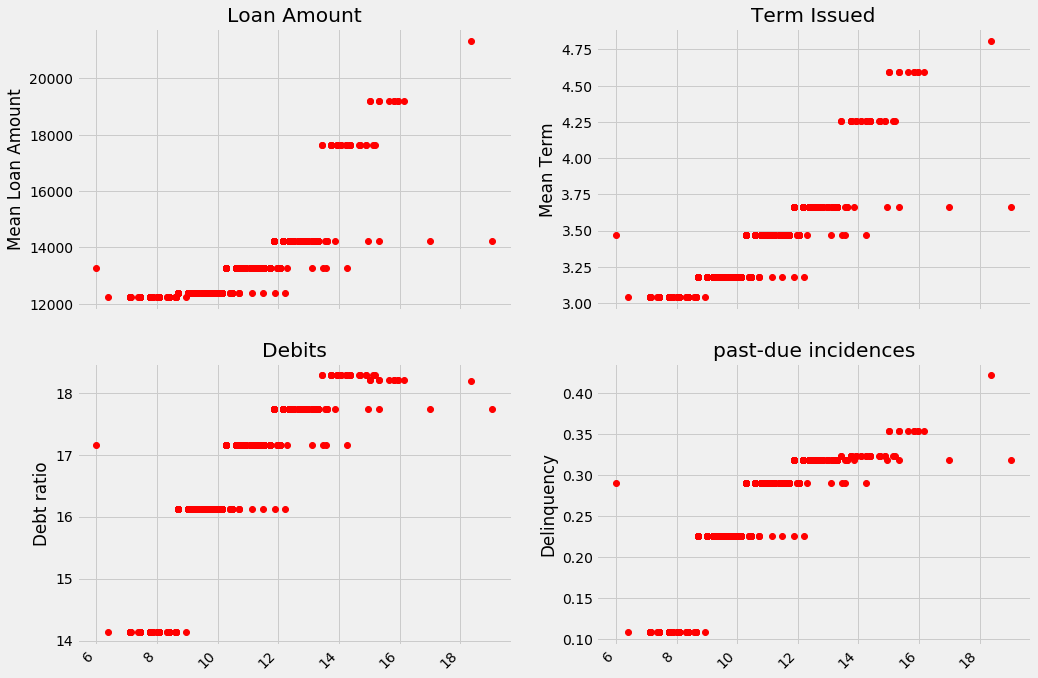

In [26]:
# Import matplotlib for plotting and use magic command for Jupyter Notebooks
import matplotlib.pyplot as plt

%matplotlib inline
features_later = features

features_later.head(5)

interest_rate = features_later['int_rate'].loc[:500]


# Set the style
plt.style.use('fivethirtyeight')

# Set up the plotting layout
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize = (15,10))
fig.autofmt_xdate(rotation = 45)

# Historical Average Max Temp
ax1.plot(interest_rate, features['mean_loan_amt'].loc[:500],'ro')
ax1.set_xlabel(''); ax1.set_ylabel('Mean Loan Amount'); ax1.set_title('Loan Amount')

# Prior Avg Wind Speed 
ax2.plot(interest_rate, features['mean_term'].loc[:500], 'ro')
ax2.set_xlabel(''); ax2.set_ylabel('Mean Term'); ax2.set_title('Term Issued')

# Prior Precipitation
ax3.plot(interest_rate, features['mean_dti'].loc[:500], 'ro')
ax3.set_xlabel(''); ax3.set_ylabel('Debt ratio'); ax3.set_title('Debits')

# Prior Snowdepth
ax4.plot(interest_rate, features['mean_delinq_2yrs'].loc[:500], 'ro')
ax4.set_xlabel(''); ax4.set_ylabel('Delinquency'); ax4.set_title('past-due incidences')

plt.tight_layout(pad=2)

In [27]:
# One Hot Encoding
features = pd.get_dummies(features)

# Extract features and labels
labels = features['int_rate']
features = features.drop('int_rate', axis = 1)
# print(features.columns)
# List of features for later use
feature_list = list(features.columns)

# Convert to numpy arrays
import numpy as np

features = np.array(features)
labels = np.array(labels)

# Training and Testing sets
from sklearn.model_selection import train_test_split

train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (190642, 214)
Training Labels Shape: (190642,)
Testing Features Shape: (63548, 214)
Testing Labels Shape: (63548,)


In [32]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics


# Random forest with only the most important variables
rf_most_important = RandomForestRegressor(n_estimators= 1000, random_state=42)

# Extract the most important features
important_indices = [feature_list.index('mean_loan_amt'), 
                     feature_list.index('mean_funded_amnt'), 
                     feature_list.index('mean_term'),
                     feature_list.index('mean_annual_inc'), 
                     feature_list.index('mean_dti'), 
                     feature_list.index('mean_delinq_2yrs'), 
                     feature_list.index('mean_mths_since_last_delinq'), 
                     feature_list.index('mean_open_cc'), 
                     feature_list.index('mean_pub_rec'), 
                     feature_list.index('mean_revol_bal'), 
                     feature_list.index('mean_total_paymnt'), 
                     feature_list.index('mean_rec_int'), 
                     feature_list.index('mean_total_rec_late_fee'), 
                     feature_list.index('mean_recoveries'), 
                     feature_list.index('mean_dti_joint'), 
                     feature_list.index('mean_annual_inc_joint'), 
                     feature_list.index('mean_total_cur_bal')]

train_important = train_features[:, important_indices]
test_important = test_features[:, important_indices]

# Train the random forest
rf_most_important.fit(train_important, train_labels)

# Make predictions and determine the error
predictions = rf_most_important.predict(test_important)
errors = abs(predictions - test_labels)

# Display the performance metrics
print('Mean Absolute Error:', round(np.mean(errors), 2))

mape = np.mean(100 * (errors / test_labels))
print('MAPE value is:', mape)
accuracy = 100 - mape
print('Accuracy:', round(accuracy, 2), '%.')

print('Mean Absolute Error:', metrics.mean_absolute_error(test_labels, predictions))  
print('Mean Absolute Percentage Error value is:', mape)
print('Mean Squared Error:', metrics.mean_squared_error(test_labels, predictions))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(test_labels, predictions))) 
print('Accuracy:', round(accuracy, 2), '%.')

Mean Absolute Error: 1.06
MAPE value is: 8.434945851378119
Accuracy: 91.57 %.
Mean Absolute Error: 1.058281080947692
Mean Absolute Percentage Error value is: 8.434945851378119
Mean Squared Error: 1.7447602861359497
Root Mean Squared Error: 1.3208937452103973
Accuracy: 91.57 %.


In [33]:
#Feature Importances

# Get numerical feature importances
importances = list(rf_most_important.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: delinq_2yrs          Importance: 0.17
Variable: member_id            Importance: 0.09
Variable: loan_amnt            Importance: 0.09
Variable: dti                  Importance: 0.09
Variable: revol_bal            Importance: 0.09
Variable: annual_inc           Importance: 0.08
Variable: total_pymnt          Importance: 0.08
Variable: total_rec_int        Importance: 0.08
Variable: total_rec_late_fee   Importance: 0.08
Variable: funded_amnt          Importance: 0.07
Variable: open_acc             Importance: 0.07
Variable: mths_since_last_delinq Importance: 0.01
Variable: term(years)          Importance: 0.0
Variable: pub_rec              Importance: 0.0
Variable: recoveries           Importance: 0.0
Variable: annual_inc_joint     Importance: 0.0
Variable: dti_joint            Importance: 0.0


Text(0.5, 1.0, 'Cumulative Importances')

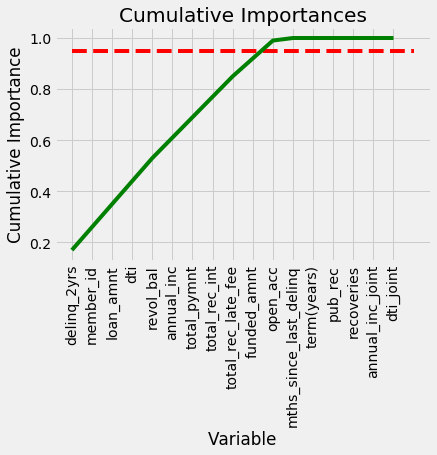

In [35]:
#Visualize Feature Importances

# List of features sorted from most to least important
sorted_importances = [importance[1] for importance in feature_importances]
sorted_features = [importance[0] for importance in feature_importances]

# Cumulative importances
cumulative_importances = np.cumsum(sorted_importances)
x_values = list(range(len(importances)))

# Make a line graph
plt.plot(x_values, cumulative_importances, 'g-')

# Draw line at 95% of importance retained
plt.hlines(y = 0.95, xmin=0, xmax=len(sorted_importances), color = 'r', linestyles = 'dashed')

# Format x ticks and labels
plt.xticks(x_values, sorted_features, rotation = 'vertical')

# Axis labels and title
plt.xlabel('Variable'); plt.ylabel('Cumulative Importance'); plt.title('Cumulative Importances')

In [36]:
#Limit Number of Features

# Find number of features for cumulative importance of 95%
# Add 1 because Python is zero-indexed
print('Number of features for 95% importance:', np.where(cumulative_importances > 0.95)[0][0] + 1)

# Extract the names of the most important features
important_feature_names = [feature[0] for feature in feature_importances[0:11]]

# print(important_feature_names)
# Find the columns of the most important features
important_indices = [feature_list.index(feature) for feature in important_feature_names]

# Create training and testing sets with only the important features
important_train_features = train_features[:, important_indices]
important_test_features = test_features[:, important_indices]

# Sanity check on operations
print('Important train features shape:', important_train_features.shape)
print('Important test features shape:', important_test_features.shape)

Number of features for 95% importance: 11
Important train features shape: (190642, 11)
Important test features shape: (63548, 11)


In [37]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics


# Random forest with only the most important variables
rf_most_important = RandomForestRegressor(n_estimators= 1000, random_state=42)

# Extract the most important features
important_indices = [feature_list.index('mean_loan_amt'), 
                     feature_list.index('mean_funded_amnt'), 
                     feature_list.index('mean_term'),
                     feature_list.index('mean_annual_inc'), 
                     feature_list.index('mean_delinq_2yrs'), 
                     feature_list.index('mean_mths_since_last_delinq'), 
                     feature_list.index('mean_pub_rec'), 
                     feature_list.index('mean_revol_bal'), 
                     feature_list.index('mean_total_paymnt'), 
                     feature_list.index('mean_dti_joint'), 
                     feature_list.index('mean_annual_inc_joint'), 
                     feature_list.index('mean_total_cur_bal')]

train_important = train_features[:, important_indices]
test_important = test_features[:, important_indices]

# Train the random forest
rf_most_important.fit(train_important, train_labels)

# Make predictions and determine the error
predictions = rf_most_important.predict(test_important)
errors = abs(predictions - test_labels)

# Display the performance metrics
mape = np.mean(100 * (errors / test_labels))
accuracy = 100 - mape

print('Mean Absolute Error:', metrics.mean_absolute_error(test_labels, predictions))  
print('Mean Absolute Percentage Error value is:', mape)
print('Mean Squared Error:', metrics.mean_squared_error(test_labels, predictions))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(test_labels, predictions))) 
print('Accuracy:', round(accuracy, 2), '%.')

Mean Absolute Error: 1.0582810809476917
Mean Absolute Percentage Error value is: 8.434945851378117
Mean Squared Error: 1.7447602861359501
Root Mean Squared Error: 1.3208937452103973
Accuracy: 91.57 %.


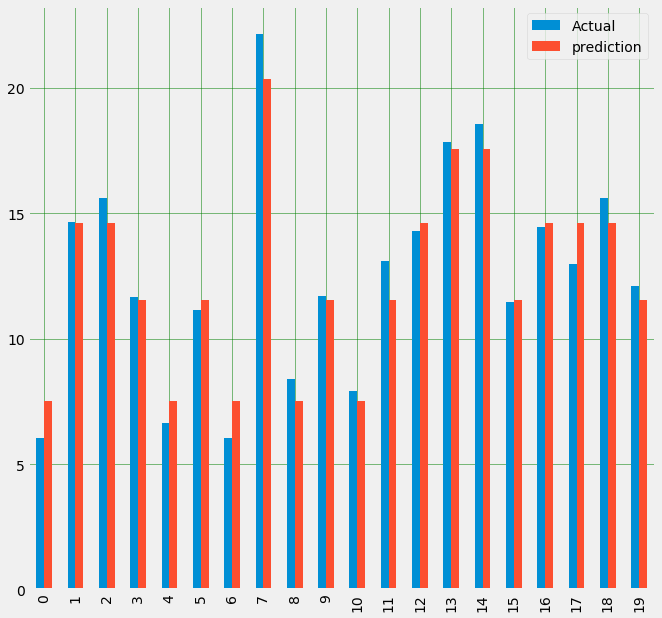

In [38]:
# Dataframe with predictions and actual
predictions_data = pd.DataFrame(data = {'Actual': test_labels, 'prediction': predictions})

#print the values
prd = predictions_data.head(20)

#plot the values for comparison
prd.plot(kind='bar',figsize=(10,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()